## Imports

In [1]:
import pandas as pd
import numpy as np
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import os

## Datasets paths

In [2]:
train_dir = '../dataset/train/'
test_dir = '../dataset/test1/'
print(os.listdir("../dataset"))

['sampleSubmission.csv', 'test1', 'train']


## Image properties

In [3]:
FAST_RUN = False
# Largura imagem
Image_Width = 128
# Altura imagem
Image_Height = 128
# Tamanho da imagem
Image_Size = (Image_Width, Image_Height)
# Canais de imagem
Image_Channels = 3

## Prepare dataset for training model:

In [4]:
filenames = os.listdir(train_dir)
categories = []
for file in filenames:
    category = file.split('.')[0]    
    if category == 'dog':
        categories.append(1)
    else:     
        categories.append(0)

df = pd.DataFrame({
    'filename' : filenames,
    'category' : categories
    })

In [5]:
df.head()

,filename,category
0,cat.0.jpg,0
1,cat.1.jpg,0
2,cat.10.jpg,0
3,cat.100.jpg,0
4,cat.1000.jpg,0


In [6]:
df.tail()

,filename,category
24995,dog.9995.jpg,1
24996,dog.9996.jpg,1
24997,dog.9997.jpg,1
24998,dog.9998.jpg,1
24999,dog.9999.jpg,1


## Total de arquivos

<AxesSubplot:>

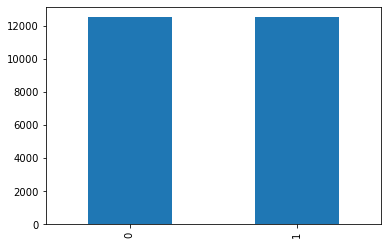

In [7]:
df['category'].value_counts().plot.bar()

## Amostra de imagem

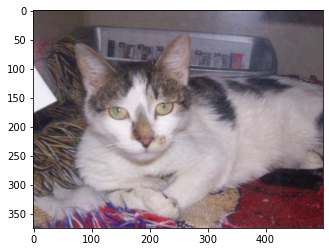

In [8]:
sample = random.choice(filenames)
image = load_img(train_dir + sample)
plt.imshow(image)

## Inicializando a rede neural convolucional

### Imports

In [9]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dropout, Flatten
from tensorflow.keras.layers import BatchNormalization, Dense
from tensorflow.keras.layers import Activation

In [ ]:
model = Sequential()

## Conv_1

In [10]:
model.add(Conv2D(32, (3, 3), activation = 'relu', input_shape=
                (128, 128, 3))
          )
model.add(keras.layers.Conv2D(32,
                              (3,3),
                              input_shape=(Image_Width, Image_Height, Image_Channels),
                              activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(0.25))

## Conv_2

In [11]:
model.add(Conv2D(64, (3, 3), activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(0.25))

## Conv_3

In [12]:
model.add(Conv2D(128, (3, 3), activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.25))

## Flatten

In [13]:
model.add(Flatten())
model.add(Dense(512, activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(2, activation = 'softmax'))

## Optimizer and loss

In [14]:
model.compile(loss = 'categorical_crossentropy',
              optimizer = 'rmsprop',              
              metrics = ['accuracy']
              )

## Analyzing model

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 124, 124, 32)      9248      
_________________________________________________________________
batch_normalization (BatchNo (None, 124, 124, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 62, 62, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 62, 62, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 60, 60, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 60, 60, 64)        2

## Define callbacks and learning rate

### Imports

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping    
from tensorflow.keras.callbacks import ReduceLROnPlateau

In [ ]:
earlystop = EarlyStopping(patience = 10)

In [16]:
learning_rate_reduction = ReduceLROnPlateau(monitor = 'val_accuracy',
                                            patience = 2,
                                            verbose = 1,
                                            factor = 0.5,
                                            min_lr = 0.00001
                                            )

In [ ]:
callbacks = [earlystop, learning_rate_reduction]

## Manage data

In [ ]:
df["category"] = df["category"].replace({ 0 : 'cat', 1 : 'dog' })

In [17]:
train_df, validate_df = train_test_split(df, test_size = 0.30,
                                         random_state = 42)
train_df = train_df.reset_index(drop = True)
validate_df = validate_df.reset_index(drop = True)

<AxesSubplot:>

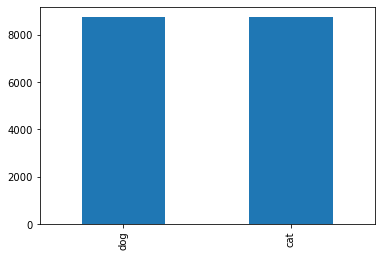

In [18]:
train_df['category'].value_counts().plot.bar()

<AxesSubplot:>

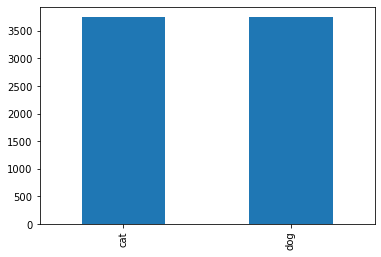

In [19]:
validate_df['category'].value_counts().plot.bar()

In [20]:
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
batch_size = 15

## Treinamento

In [21]:
train_datagen = ImageDataGenerator(rotation_range = 15,
                                   rescale = 1./255,
                                   shear_range = 0.1,
                                   zoom_range = 0.2,
                                   horizontal_flip = True,
                                   width_shift_range = 0.1,
                                   height_shift_range = 0.1,
                                   )

train_generator = train_datagen.flow_from_dataframe(train_df,
                                                    train_dir,
                                                    x_col = 'filename',
                                                    y_col = 'category',
                                                    target_size = Image_Size,
                                                    class_mode = 'categorical',
                                                    batch_size = batch_size
                                                    )

Found 17500 validated image filenames belonging to 2 classes.


## Validation data generator

In [22]:
validation_datagen  = ImageDataGenerator(rescale = 1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df,
    train_dir,
    x_col = 'filename',
    y_col = 'category',
    target_size = Image_Size,
    class_mode = 'categorical',
    batch_size = batch_size
    )

Found 7500 validated image filenames belonging to 2 classes.


## See how our generator work

In [23]:
example_df = train_df.sample(n = 1).reset_index(drop = True)
example_generator = train_datagen.flow_from_dataframe(
    example_df,
    train_dir,
    x_col = 'filename',
    y_col = 'category',
    target_size = Image_Size,
    class_mode = 'categorical')

Found 1 validated image filenames belonging to 1 classes.


<function matplotlib.pyplot.show(close=None, block=None)>

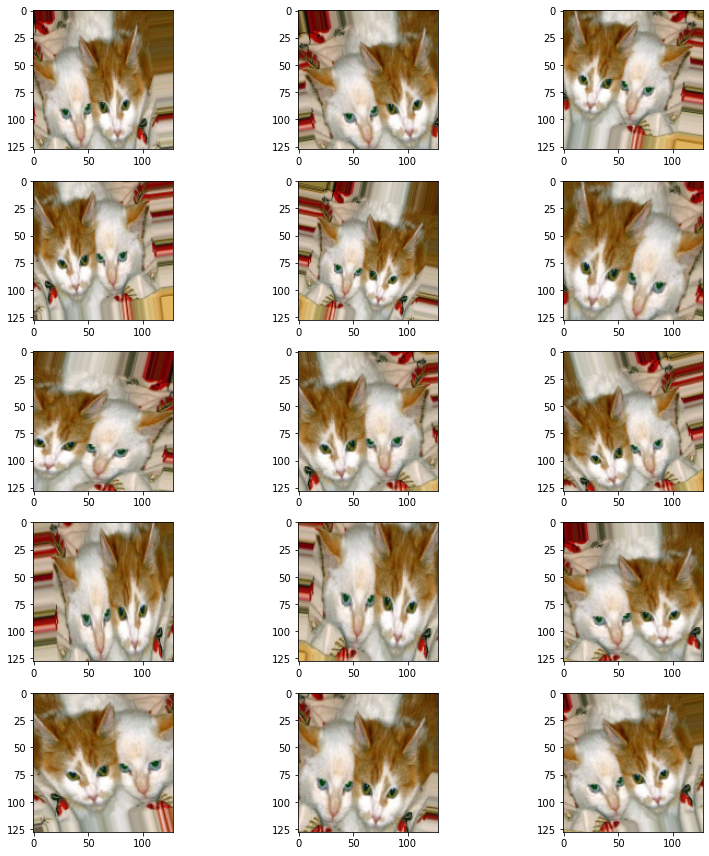

In [24]:
plt.figure(figsize = (12, 12))
for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()        
plt.show

## Treinando modelo

In [25]:
epochs = 3 if FAST_RUN else 50
history = model.fit(
    train_generator,
    epochs = epochs,
    validation_data = validation_generator,
    validation_steps = total_validate//batch_size,
    steps_per_epoch = total_validate//batch_size,
    callbacks = callbacks    
    )        

Epoch 1/50
500/500 [==============================] - 587s 1s/step - loss: 0.9298 - accuracy: 0.5753 - val_loss: 0.8578 - val_accuracy: 0.5584
Epoch 2/50
500/500 [==============================] - 551s 1s/step - loss: 0.6604 - accuracy: 0.6351 - val_loss: 0.7128 - val_accuracy: 0.6292
Epoch 3/50
500/500 [==============================] - 542s 1s/step - loss: 0.5950 - accuracy: 0.6927 - val_loss: 0.5824 - val_accuracy: 0.7120
Epoch 4/50
500/500 [==============================] - 535s 1s/step - loss: 0.5781 - accuracy: 0.7067 - val_loss: 0.5472 - val_accuracy: 0.7163
Epoch 5/50
500/500 [==============================] - 532s 1s/step - loss: 0.5511 - accuracy: 0.7247 - val_loss: 0.6196 - val_accuracy: 0.6741
Epoch 6/50
500/500 [==============================] - 532s 1s/step - loss: 0.5328 - accuracy: 0.7349 - val_loss: 0.4819 - val_accuracy: 0.7673
Epoch 7/50
500/500 [==============================] - 540s 1s/step - loss: 0.5287 - accuracy: 0.7469 - val_loss: 0.4610 - val_accuracy: 0.7831

500/500 [==============================] - 546s 1s/step - loss: 0.2907 - accuracy: 0.8760 - val_loss: 0.2222 - val_accuracy: 0.9071


## Save the model

In [26]:
model.save("model_cats_dogs1.h5")

## Virtualize Training

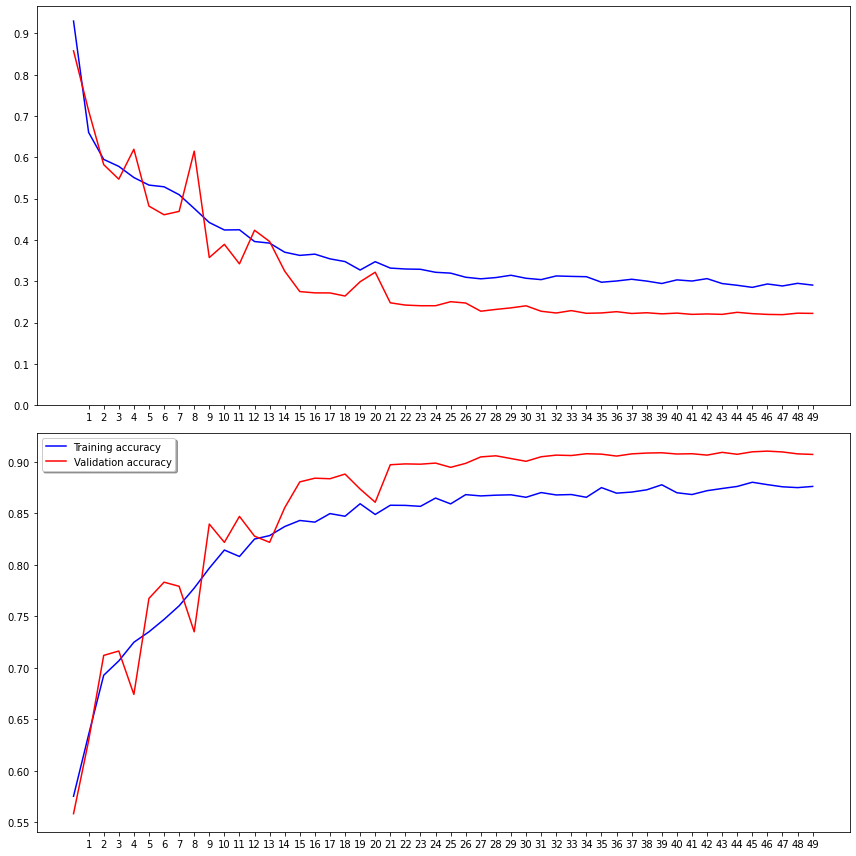

In [31]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize = (12, 12))
ax1.plot(history.history['loss'], 
         color = 'b', 
         label = "Training loss")
ax1.plot(history.history['val_loss'], 
         color = 'r',
         label = "validation loss")
ax1.set_xticks(np.arange(1, epochs, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(history.history['accuracy'],
         color = 'b',
         label = "Training accuracy")
ax2.plot(history.history['val_accuracy'],
         color = 'r',
         label = "Validation accuracy")
ax2.set_xticks(np.arange(1, epochs, 1))

legend = plt.legend(loc = 'best', shadow = True)
plt.tight_layout()
plt.show()

## Test data preparation

In [32]:
test_filenames = os.listdir(test_dir)
test_df = pd.DataFrame({
    'filename' : test_filenames
    })
nb_samples = test_df.shape[0]

## Create testing generator

In [33]:
test_datagen = ImageDataGenerator(rotation_range = 15,
                                  rescale = 1./255,                                  
                                  shear_range = 0.1,
                                  zoom_range = 0.2,
                                  horizontal_flip = True,
                                  width_shift_range = 0.1,
                                  height_shift_range = 0.1
                                  )
test_generator = test_datagen.flow_from_dataframe(test_df,
                                                  test_dir,
                                                  x_col = 'filename',
                                                  y_col = None,
                                                  target_size = Image_Size,
                                                  class_mode = None,
                                                  batch_size = batch_size,
                                                  shuffle = False
                                                  )

Found 12500 validated image filenames.


## Make categorical prediction

In [34]:
predict = model.predict(test_generator,
                        steps = np.ceil(nb_samples/batch_size))

## Convert labels to categories

In [35]:
test_df['category'] = np.argmax(predict, axis = -1)

label_map = dict((v, k) for k, v in train_generator.class_indices.items())
test_df['category'] = test_df['category'].replace(label_map)

test_df['category'] = test_df['category'].replace({'dog' : 1, 'cat' : 0})

## Virtualize result

<AxesSubplot:>

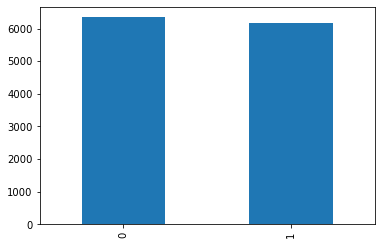

In [36]:
test_df['category'].value_counts().plot.bar()

### Visualize the prediction results

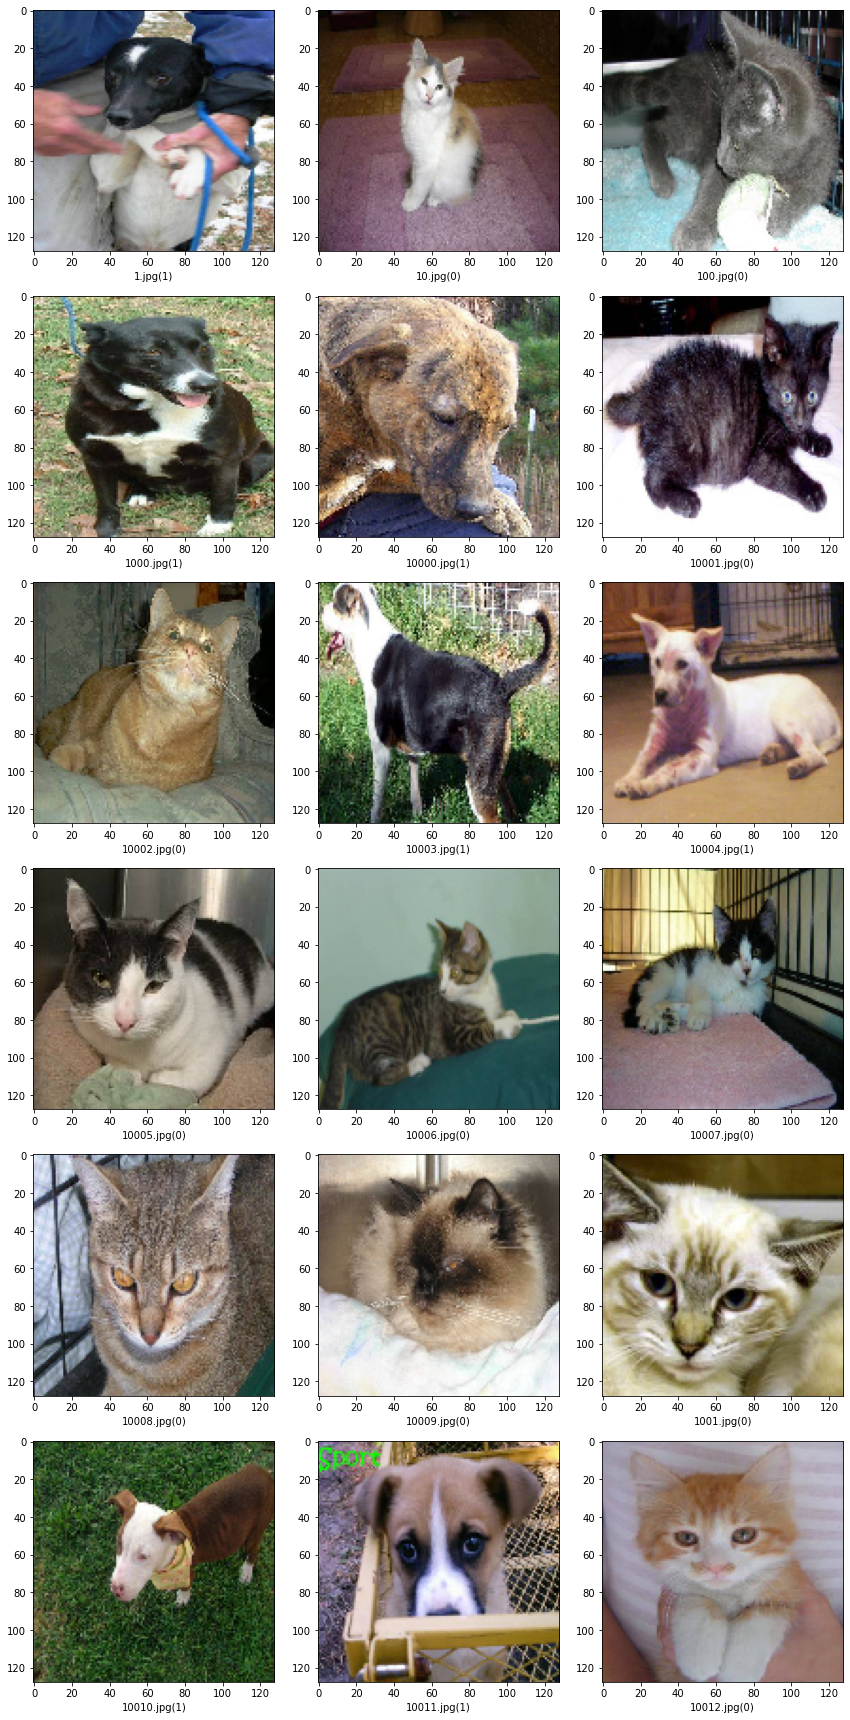

In [41]:
sample_test = test_df.head(18)
sample_test.head()
plt.figure(figsize = (12, 24))
for index, row in sample_test.iterrows():
    filename = row['filename']
    category = row['category']
    img = load_img(test_dir + filename,
                   target_size = Image_Size)
    plt.subplot(6, 3, index + 1)
    plt.imshow(img)
    plt.xlabel(filename + '(' + "{}".format(category) + ')')

plt.tight_layout()    
plt.show()